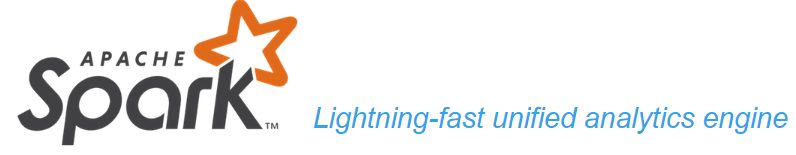

# Spark MLlib 
Spark MLlib is Spark Machine Learning (ML) liabrary. At high level it provides tools to develop scalable ML model such as:

- ML Algorithms: common learning algorithms such as classification, regression, clustering, and collaborative filtering
- Featurization: feature extraction, transformation, dimensionality reduction, and selection
- Pipelines: tools for constructing, evaluating, and tuning ML Pipelines
- Training and Tunning: Tools for model training and tunning
- Persistence: saving and load algorithms, models, and Pipelines
- Utilities: linear algebra, statistics, data handling, etc.

Spark ML has tow types of packages
- RDD Based package:<a href="https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html" target="_blank">org.apache.spark.mllib</a>
- DataFrame based package: <a href="https://spark.apache.org/docs/latest/api/python/pyspark.ml.html" target="_blank">org.apache.spark.ml</a>


# Highlevel MLlib concept

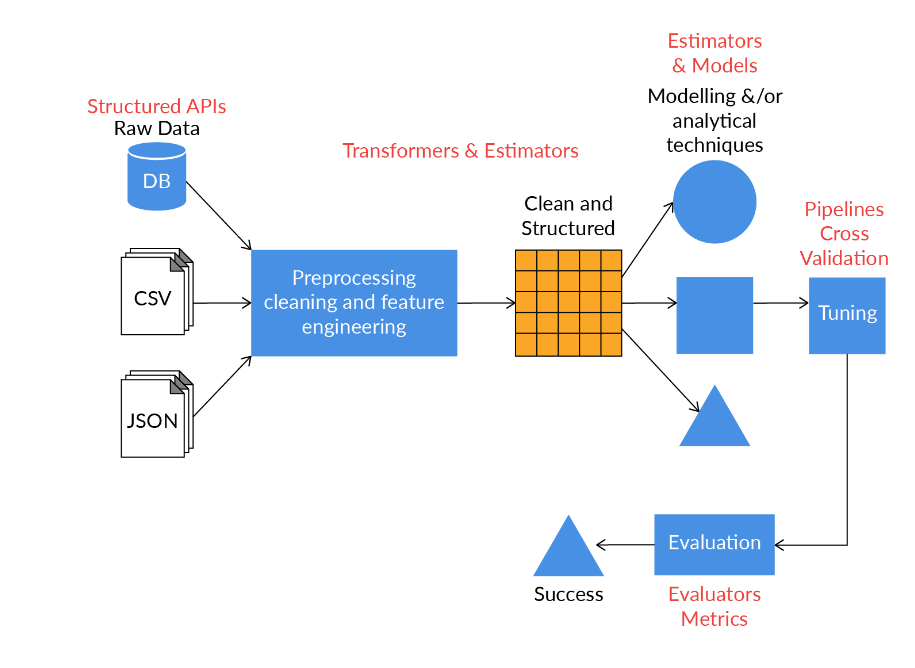

In MLlib there are several fundamental “structural” types: transformers, estimators, evaluators, and pipelines. Above workflow shows overall process when you are developing Machine Learning Model using Spark

The overall process involves, the following steps (with some variation):

1. Gathering and collecting the relevant data for your task.

2. Cleaning and inspecting the data to better understand it.

3. Performing feature engineering to allow the algorithm to leverage the data in a suitable form (e.g., converting the data to numerical vectors).

4. Using a portion of this data as a training set to train one or more algorithms to generate some candidate models.

5. Evaluating and comparing models against your success criteria by objectively measuring results on a subset of the same data that was not used for training. This allows you to better understand how your model may perform in the wild.

6. Leveraging the insights from the above process and/or using the model to make predictions, detect anomalies, or solve more general business challenges.

# <a href="http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.Transformer" target="_blank">Transformer</a>

Transformer are basically used for PreProcessing and Feature Engineering. Transfors are the fuctions that prepare your raw data into way Spark ML can work. Transformer takes DataFrame as input and produces Dataframe as output.

Transformer got transform() method which convert one DataFrame into Another DataFrame.


# Estimators
An <a href="http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.Estimator" target="_blank">Estimator</a> abstracts the concept of a learning algorithm or any algorithm that fits or trains on data. Technically, an Estimator implements a method fit(), which accepts a DataFrame and produces a Model. For example, a learning algorithm such as LogisticRegression is an Estimator, and calling fit() trains a LogisticRegression, which is a Model

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("Spark ML") \
    .getOrCreate()

In [ ]:
# importing PCA and Vectors
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors

# sparse and dense vectors
data = [(Vectors.sparse(5, [(1, 1.0), (3, 7.0)]),), 
        (Vectors.dense([2.0, 0.0, 3.0, 4.0, 5.0]),),
        (Vectors.dense([4.0, 0.0, 0.0, 6.0, 7.0]),)]

df = spark.createDataFrame(data, ["features"])

pca = PCA(k=3, inputCol="features", outputCol="pcaFeatures")

model = pca.fit(df)
result = model.transform(df).select("pcaFeatures")
result.show(truncate=False)

# Evaluator 
An <a href="http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#module-pyspark.ml.tuning" target="_blank">Evaluator</a> allows us to see how a given model performs according to criteria we specify like a receiver operating characteristic (ROC) curve. After we use an evaluator to select the best model from the ones we tested, we can then use that model to make predictions

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.linalg import Vectors

dataset = spark.createDataFrame(
         [(Vectors.dense([0.0]), 0.0),
          (Vectors.dense([0.4]), 1.0),
          (Vectors.dense([0.5]), 0.0),
          (Vectors.dense([0.6]), 1.0),
          (Vectors.dense([1.0]), 1.0)] * 10,
         ["features", "label"])

lr = LogisticRegression()
grid = ParamGridBuilder().addGrid(lr.maxIter, [0, 1]).build()

evaluator = BinaryClassificationEvaluator()
cv = CrossValidator(estimator=lr, estimatorParamMaps=grid, evaluator=evaluator,parallelism=2)
cvModel = cv.fit(dataset)
cvModel.avgMetrics[0]
evaluator.evaluate(cvModel.transform(dataset))

# PipeLine 
<a href="https://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html#module-pyspark.ml" target=_blank> ML Pipeline</a> DataFrame-based machine learning APIs to let users quickly assemble and configure practical machine learning pipelines.
A simple pipeline, which acts as an estimator. A Pipeline consists of a sequence of stages, each of which is either an Estimator or a Transformer. When Pipeline.fit() is called, the stages are executed in order. 

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer

# Prepare training documents, which are labeled.
training = spark.createDataFrame([
    (0, "a b c d e spark", 1.0),
    (1, "b d", 0.0),
    (2, "spark f g h", 1.0),
    (3, "hadoop mapreduce", 0.0),
    (4, "b spark who", 1.0),
    (5, "g d a y", 0.0),
    (6, "spark fly", 1.0),
    (7, "was mapreduce", 0.0),
    (8, "e spark program", 1.0),
    (9, "a e c l", 0.0),
    (10, "spark compile", 1.0),
    (11, "hadoop software", 0.0)
], ["id", "text", "label"])

In [ ]:
# Configure an ML pipeline, which consists of tree stages: tokenizer, hashingTF, and lr.
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10)
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])
type(pipeline)
model1=pipeline.fit(training)

# Persisting and applying Model

Once you’ve used an estimator to configure a transformer, it can be helpful to write it to disk and simply load it when necessary (e.g., for use in another Spark session). We saw this in the previous chapter when we persisted an entire pipeline. To persist a transformer individually, we use the write method on the fitted transformer (or the standard transformer) and specify the location:

In [ ]:
mlpath="/user/sanskar.agrawal_upgrad/modelLocation"
model1.write().overwrite().save(mlpath)

In [ ]:
print("Model Trained")
print("Model is ", model1)
print("Model Stages", model1.stages)

In [ ]:
from  pyspark.ml import PipelineModel
model2=PipelineModel.load(mlpath)
assert str(model1) == str(model2)
print("loaded model from {}".format(mlpath))
#model2.transform(test).select("label", "prediction").collect()
print("Model Trained")
print("Model is ", model2)
print("Model Stages", model2.stages)
